In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Basic imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv')

# Basic preview
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


event_type
view        63556110
cart         3028930
purchase      916939
Name: count, dtype: int64


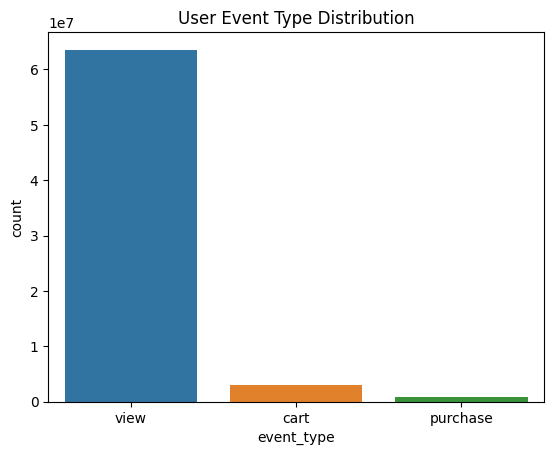

In [3]:
event_counts = df['event_type'].value_counts()
print(event_counts)

sns.countplot(x='event_type', data=df)
plt.title("User Event Type Distribution")
plt.show()

In [18]:
#FUNNEL ANALYSIS

# Convert 'event_time' to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Sort data by user and time
df_sorted = df.sort_values(['user_id', 'event_time'])

# Group by user and find their events
user_events = df_sorted.groupby('user_id')['event_type'].apply(list)

# Create counts for each funnel stage
view_count = (user_events.apply(lambda x: 'view' in x)).sum()
cart_count = (user_events.apply(lambda x: 'cart' in x)).sum()
purchase_count = (user_events.apply(lambda x: 'purchase' in x)).sum()

# Funnel Summary
funnel = pd.DataFrame({
    'Stage': ['View', 'Cart', 'Purchase'],
    'Users': [view_count, cart_count, purchase_count]
})

# Conversion Rate
funnel['Conversion %'] = funnel['Users'] / funnel['Users'][0] * 100

# Display funnel
funnel

,Stage,Users,Conversion %
0,View,3695598,100.000000
1,Cart,826323,22.359656
2,Purchase,441638,11.950380


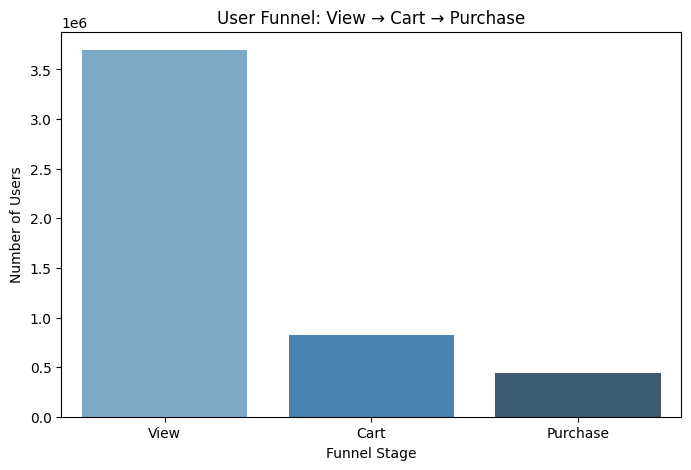

In [19]:
# Funnel plot
plt.figure(figsize=(8, 5))
sns.barplot(data=funnel, x='Stage', y='Users', palette='Blues_d')
plt.title("User Funnel: View → Cart → Purchase")
plt.xlabel("Funnel Stage")
plt.ylabel("Number of Users")
plt.show()

In [1]:
#RETENTION ANALYSIS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from the Kaggle path
df = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv')

# Convert event time to datetime again
df['event_time'] = pd.to_datetime(df['event_time'])

# Extract event date
df['event_date'] = df['event_time'].dt.date

# First active day per user
first_activity = df.groupby('user_id')['event_date'].min().reset_index()
first_activity.columns = ['user_id', 'first_date']

# Merge back to the original
df = df.merge(first_activity, on='user_id')

# Days since first activity
df['days_since_first'] = (pd.to_datetime(df['event_date']) - pd.to_datetime(df['first_date'])).dt.days

# Retention table
retention = df.groupby(['first_date', 'days_since_first'])['user_id'].nunique().reset_index()
cohort_sizes = retention[retention['days_since_first'] == 0][['first_date', 'user_id']]
cohort_sizes.columns = ['first_date', 'cohort_size']

retention = retention.merge(cohort_sizes, on='first_date')
retention['retention_rate'] = retention['user_id'] / retention['cohort_size']

# Pivot table
retention_pivot = retention.pivot(index='first_date', columns='days_since_first', values='retention_rate')
retention_pivot.fillna(0).style.background_gradient(cmap='Blues', axis=1)


days_since_first,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
first_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-01,1.000000,0.187057,0.155490,0.164203,0.147534,0.139520,0.141680,0.135123,0.124411,0.124276,0.126876,0.125522,0.123734,0.146050,0.190733,0.212978,0.197393,0.124957,0.102430,0.096765,0.090795,0.087137,0.083381,0.082010,0.082902,0.089087,0.090288,0.088558,0.098423,0.087899
2019-11-02,1.000000,0.155102,0.134148,0.117532,0.110365,0.111624,0.107234,0.103550,0.102394,0.101347,0.096786,0.095698,0.113231,0.154397,0.181637,0.170297,0.098367,0.081010,0.076284,0.072832,0.070624,0.069619,0.068867,0.066323,0.072086,0.073397,0.070764,0.079445,0.073946,0.000000
2019-11-03,1.000000,0.146860,0.114548,0.104455,0.104107,0.099363,0.095524,0.096321,0.093678,0.091981,0.089384,0.106015,0.145715,0.171585,0.164095,0.093171,0.075543,0.069084,0.066942,0.062881,0.063143,0.063172,0.060985,0.066293,0.067221,0.064994,0.072097,0.067267,0.000000,0.000000
2019-11-04,1.000000,0.137367,0.111233,0.105713,0.097326,0.087043,0.086269,0.093941,0.091416,0.087396,0.104213,0.140853,0.168444,0.157419,0.091234,0.073317,0.067984,0.063024,0.060328,0.056153,0.056837,0.058481,0.062271,0.064306,0.062175,0.070093,0.060670,0.000000,0.000000,0.000000
2019-11-05,1.000000,0.124914,0.103864,0.090955,0.080788,0.079495,0.084641,0.082000,0.079135,0.092360,0.124615,0.150084,0.142166,0.081751,0.066301,0.062205,0.059788,0.054008,0.050950,0.051304,0.054213,0.058582,0.057786,0.056338,0.062740,0.054412,0.000000,0.000000,0.000000,0.000000
2019-11-06,1.000000,0.125752,0.095584,0.082016,0.079392,0.081011,0.077374,0.075163,0.086162,0.119945,0.140112,0.133197,0.076974,0.062428,0.057586,0.055747,0.051387,0.049039,0.048908,0.050582,0.053006,0.053984,0.052221,0.059783,0.052531,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-07,1.000000,0.109745,0.079861,0.074114,0.076588,0.070665,0.068852,0.078454,0.108972,0.127737,0.125099,0.069834,0.058721,0.053360,0.050422,0.048347,0.045304,0.044204,0.046960,0.049263,0.049296,0.047516,0.052811,0.046659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-08,1.000000,0.107177,0.081253,0.089953,0.081084,0.077448,0.083100,0.090828,0.108007,0.106146,0.072080,0.061248,0.057604,0.054648,0.051815,0.044056,0.043699,0.050629,0.051893,0.051634,0.051141,0.057079,0.045443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-09,1.000000,0.112602,0.082458,0.071407,0.066250,0.070483,0.084918,0.106708,0.102289,0.061324,0.052121,0.049915,0.047724,0.044370,0.044393,0.043908,0.042969,0.043632,0.042880,0.041695,0.048797,0.045846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


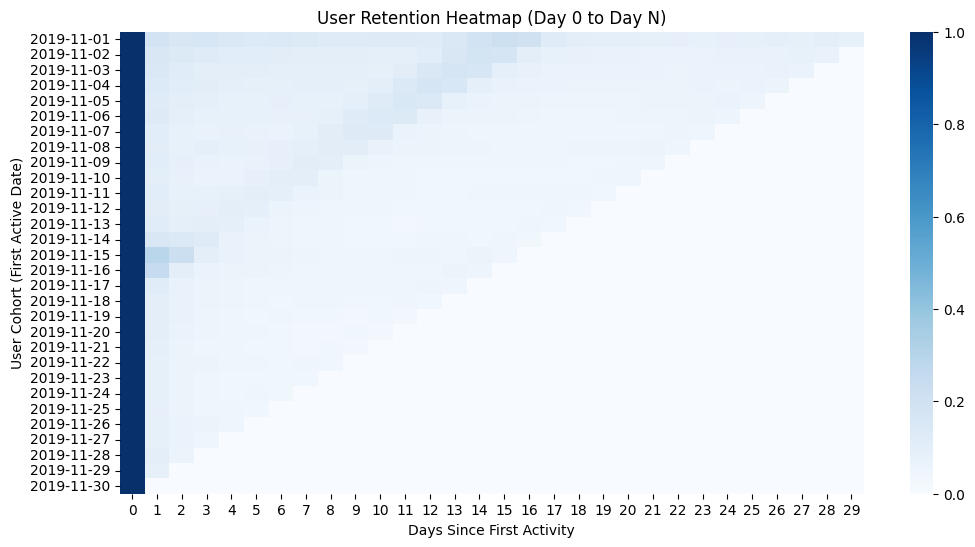

In [2]:
#RETENTION HEAT MAP

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from the Kaggle input directory
import pandas as pd

df = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv')

# Quick preview
df.head()

# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Extract event_date
df['event_date'] = df['event_time'].dt.date

# Get the first active date per user
first_activity = df.groupby('user_id')['event_date'].min().reset_index()
first_activity.columns = ['user_id', 'first_date']

# Merge with the original dataframe
df = df.merge(first_activity, on='user_id')

# Calculate days since first seen
df['days_since_first'] = (pd.to_datetime(df['event_date']) - pd.to_datetime(df['first_date'])).dt.days

# Group by cohort (first_date) and days_since_first
retention = df.groupby(['first_date', 'days_since_first'])['user_id'].nunique().reset_index()

# Get the size of each cohort
cohort_sizes = retention[retention['days_since_first'] == 0][['first_date', 'user_id']]
cohort_sizes.columns = ['first_date', 'cohort_size']

# Merge to calculate the retention rate
retention = retention.merge(cohort_sizes, on='first_date')
retention['retention_rate'] = retention['user_id'] / retention['cohort_size']

# Pivot for heatmap
retention_pivot = retention.pivot(index='first_date', columns='days_since_first', values='retention_rate')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(retention_pivot.fillna(0), cmap="Blues", annot=False, fmt=".0%")
plt.title("User Retention Heatmap (Day 0 to Day N)")
plt.xlabel("Days Since First Activity")
plt.ylabel("User Cohort (First Active Date)")
plt.show()

In [15]:
#FEATURE ADOPTION

#Check the top categories used
# Count events by category
category_counts = df['category_id'].value_counts().reset_index()
category_counts.columns = ['category_id', 'event_count']

# Display top 10 categories
category_counts.head(10)

,category_id,event_count
0,2053013555631882655,16375000
1,2053013553559896355,3277576
2,2053013554415534427,2194072
3,2053013558920217191,2166750
4,2053013554658804075,1816877
5,2053013565983425517,1498996
6,2053013563651392361,1448043
7,2053013563810775923,1403866
8,2053013553341792533,1118079
9,2053013563911439225,976484


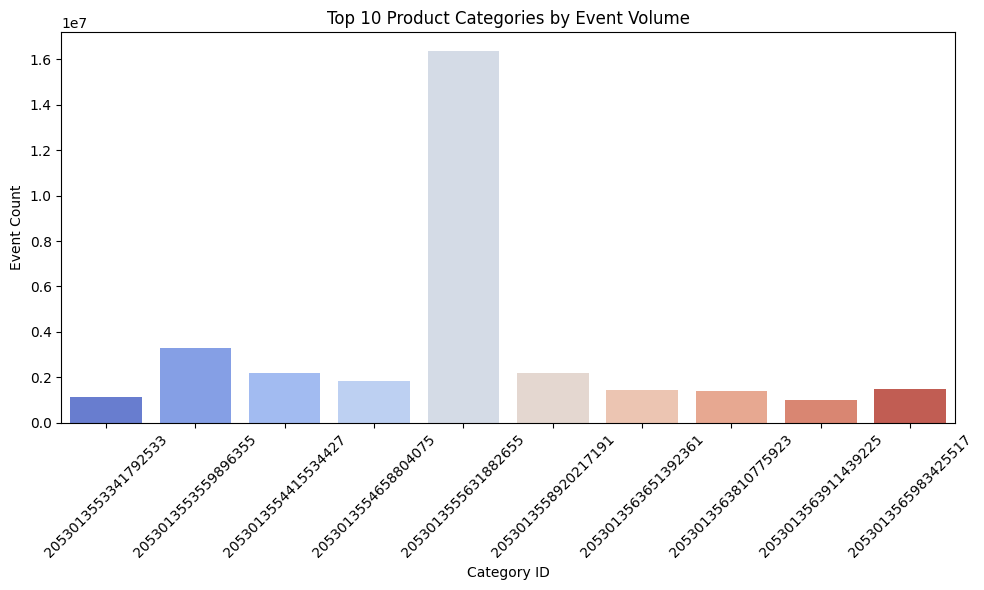

In [16]:
#Visualize top product categories

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=category_counts.head(10), x='category_id', y='event_count', palette='coolwarm')
plt.title("Top 10 Product Categories by Event Volume")
plt.xlabel("Category ID")
plt.ylabel("Event Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
#Analyzing per-user feature (category) usage
# How many unique categories did each user interact with
user_category_usage = df.groupby('user_id')['category_id'].nunique().reset_index()
user_category_usage.columns = ['user_id', 'unique_categories']

# Summary stats
user_category_usage.describe()

,user_id,unique_categories
count,3.696117e+06,3.696117e+06
mean,5.478040e+08,2.891270e+00
std,2.426419e+07,3.948387e+00
min,1.030022e+07,1.000000e+00
25%,5.236787e+08,1.000000e+00
50%,5.520038e+08,1.000000e+00
75%,5.698160e+08,3.000000e+00
max,5.799699e+08,3.060000e+02


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


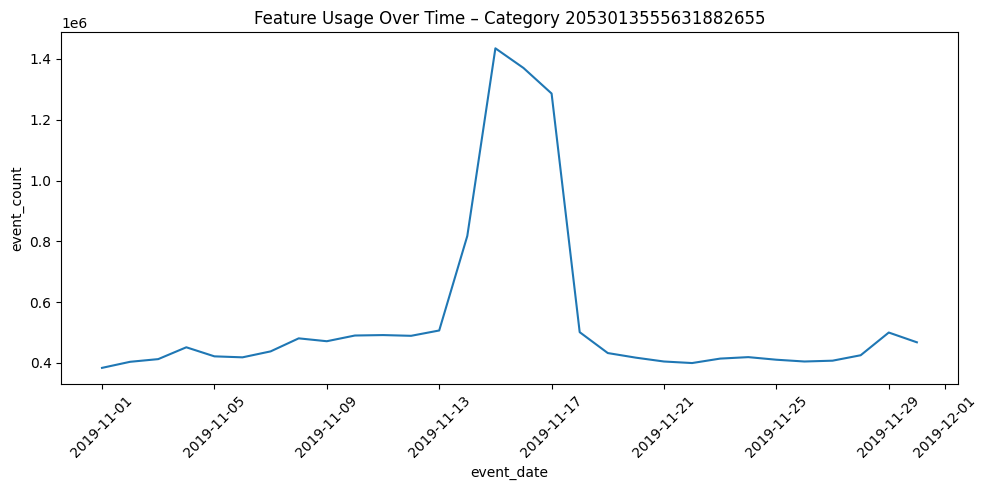

In [5]:
#Feature usage trend over time

# Group by date and category
df['event_time'] = pd.to_datetime(df['event_time'])
df['event_date'] = df['event_time'].dt.date

category_trend = df.groupby(['event_date', 'category_id'])['user_id'].count().reset_index()
category_trend.columns = ['event_date', 'category_id', 'event_count']

# Plot one category's trend (e.g., top category)
top_cat = category_counts.iloc[0]['category_id']
cat_data = category_trend[category_trend['category_id'] == top_cat]

plt.figure(figsize=(10,5))
sns.lineplot(data=cat_data, x='event_date', y='event_count')
plt.title(f"Feature Usage Over Time – Category {top_cat}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()